<div>

</div>

# Introduction to PyPowSyBl: Network representation, load flow calculation, security analysis and sensitivity analysis

@authors: Alexandre Marié ([Artelys](https://www.artelys.com/)), Coline Piloquet ([Rte](https://www.rte-france.com/)).

In [43]:
#pip install pypowsybl

In [44]:
import pypowsybl as pp

## 1 - Network presentation

The network used for this tutorial consists of 6 substations, all of which are connected by two parallel lines with the same electrotechnical characteristics (same resistance and same reactance for each line), as well as two HVDC lines and a Phase-Shifter Transformer (PST). It also has 4 generating units and three loads.

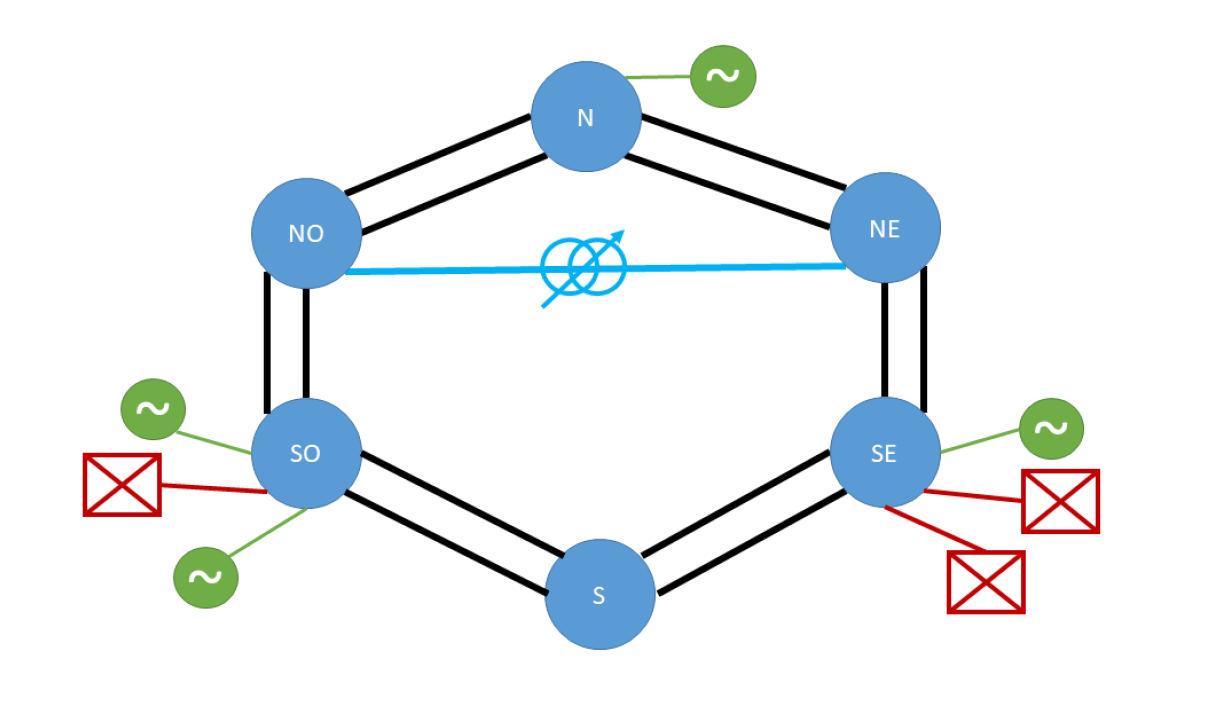

The network is available in the pyPowSyBl library and can be charged with the function create_metrix_tutorial_six_buses_network.


In this tutorial, each station and line name refers to cardinal points:

- NO: North West
- N: North
- NE: North East
- SE: South East
- S: South
- SO: South West

In [45]:
n6 = pp.network.create_metrix_tutorial_six_buses_network()

To display the network, we can draw the network area diagram. This type of diagram displays the substations and how they are connected to each other.

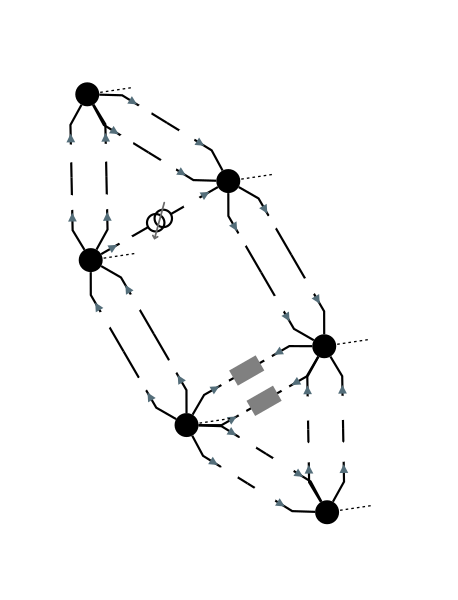

In [46]:
n6.get_network_area_diagram()

We can display node info:

In [47]:
n6.get_substations()

,name,TSO,geo_tags,country
id,,,,
NO,,,,
S,,,,
SO,,,,
SE,,,,
N,,,,


Generator info:

In [48]:
n6.get_generators()

,name,energy_source,target_p,min_p,max_p,min_q,max_q,rated_s,reactive_limits_kind,target_v,target_q,voltage_regulator_on,regulated_element_id,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,,,,,,,,,,
SO_G1,,THERMAL,480.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G1,-480.0,NaN,NaN,SO_poste,SO_poste_0,True
SO_G2,,THERMAL,480.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G2,-480.0,NaN,NaN,SO_poste,SO_poste_0,True
SE_G,,THERMAL,100.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,6.45498,True,SE_G,-0.0,NaN,NaN,SE_poste,SE_poste_0,True
N_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,7.48158,True,N_G,-0.0,NaN,NaN,N_poste,N_poste_0,True


Loads:

In [49]:
n6.get_loads()

,name,type,p0,q0,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,
SO_L,,UNDEFINED,480.0,4.8,480.0,NaN,NaN,SO_poste,SO_poste_0,True
SE_L1,,UNDEFINED,480.0,4.8,480.0,NaN,NaN,SE_poste,SE_poste_0,True
SE_L2,,UNDEFINED,0.0,4.8,0.0,NaN,NaN,SE_poste,SE_poste_0,True


## 2- Production and demand trends

Consider that production and demand evolve over 3 hourly time steps:

| Ts | SE_L1 | SO_G1 | SO_G2 |
| --- | --- | --- | --- |
| T01 | 960 | 0 | 960 |
| T02 | 960 | 960 | 0 |
| T03 | 960 | 960 | 0 |


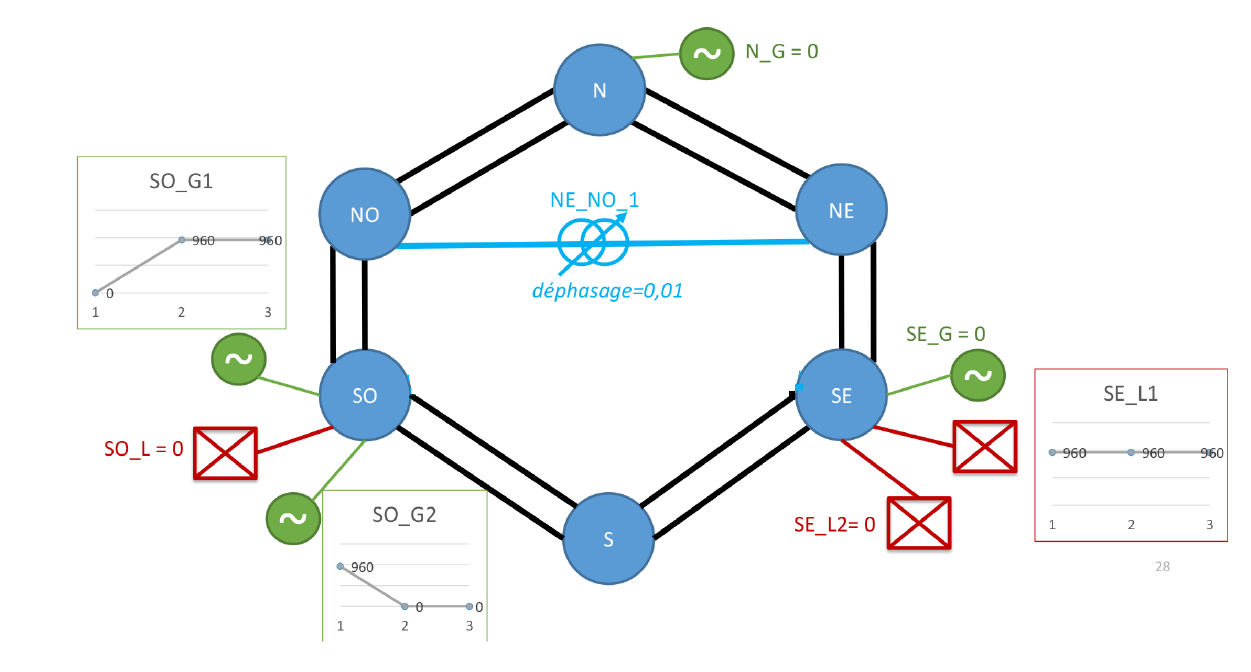

Thus, we change the production for the first time step and we display the data:

In [50]:
n6.update_generators(id='SO_G1', target_p=0)
n6.update_generators(id='SO_G2', target_p=960)
n6.update_generators(id='SE_G', target_p=0)

In [51]:
n6.get_generators()

,name,energy_source,target_p,min_p,max_p,min_q,max_q,rated_s,reactive_limits_kind,target_v,target_q,voltage_regulator_on,regulated_element_id,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,,,,,,,,,,
SO_G1,,THERMAL,0.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G1,-480.0,NaN,NaN,SO_poste,SO_poste_0,True
SO_G2,,THERMAL,960.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G2,-480.0,NaN,NaN,SO_poste,SO_poste_0,True
SE_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,6.45498,True,SE_G,-0.0,NaN,NaN,SE_poste,SE_poste_0,True
N_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,7.48158,True,N_G,-0.0,NaN,NaN,N_poste,N_poste_0,True


Then, we modify the active power loads and display the data:

In [52]:
n6.update_loads(id='SO_L', p0=0)
n6.update_loads(id='SE_L1', p0=960)
n6.update_loads(id='SE_L2', p0=0)

In [53]:
n6.get_loads()

,name,type,p0,q0,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,
SO_L,,UNDEFINED,0.0,4.8,480.0,NaN,NaN,SO_poste,SO_poste_0,True
SE_L1,,UNDEFINED,960.0,4.8,480.0,NaN,NaN,SE_poste,SE_poste_0,True
SE_L2,,UNDEFINED,0.0,4.8,0.0,NaN,NaN,SE_poste,SE_poste_0,True


## 3 - Load flow computation

We will be able to run load flow in order to analyze the base case (N):

In [54]:
results = pp.loadflow.run_dc(n6)

In [55]:
results

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, iteration_count=0, slack_bus_id='NE_poste_0', slack_bus_active_power_mismatch=-0.0, distributed_active_power=nan)]

In [56]:
n6.get_lines()

,name,r,x,g1,b1,g2,b2,p1,q1,i1,p2,q2,i2,voltage_level1_id,voltage_level2_id,bus1_id,bus2_id,connected1,connected2
id,,,,,,,,,,,,,,,,,,,
NO_N_1,,1.0,1.0,0.0,0.0,0.0,0.0,101.040745,NaN,NaN,-101.040745,NaN,NaN,NO_poste,N_poste,NO_poste_0,N_poste_0,True,True
NO_N_2,,2.0,1.0,0.0,0.0,0.0,0.0,101.040745,NaN,NaN,-101.040745,NaN,NaN,NO_poste,N_poste,NO_poste_0,N_poste_0,True,True
S_SE_1,,3.0,1.0,0.0,0.0,0.0,0.0,290.520372,NaN,NaN,-290.520372,NaN,NaN,S_poste,SE_poste,S_poste_0,SE_poste_0,True,True
S_SE_2,,4.0,1.0,0.0,0.0,0.0,0.0,290.520372,NaN,NaN,-290.520372,NaN,NaN,S_poste,SE_poste,S_poste_0,SE_poste_0,True,True
S_SO_1,,5.0,1.0,0.0,0.0,0.0,0.0,-290.520372,NaN,NaN,290.520372,NaN,NaN,S_poste,SO_poste,S_poste_0,SO_poste_0,True,True
S_SO_2,,6.0,1.0,0.0,0.0,0.0,0.0,-290.520372,NaN,NaN,290.520372,NaN,NaN,S_poste,SO_poste,S_poste_0,SO_poste_0,True,True
SO_NO_1,,7.0,1.0,0.0,0.0,0.0,0.0,189.479628,NaN,NaN,-189.479628,NaN,NaN,SO_poste,NO_poste,SO_poste_0,NO_poste_0,True,True
SO_NO_2,,8.0,1.0,0.0,0.0,0.0,0.0,189.479628,NaN,NaN,-189.479628,NaN,NaN,SO_poste,NO_poste,SO_poste_0,NO_poste_0,True,True
NE_N_1,,9.0,1.0,0.0,0.0,0.0,0.0,-101.040745,NaN,NaN,101.040745,NaN,NaN,NE_poste,N_poste,NE_poste_0,N_poste_0,True,True


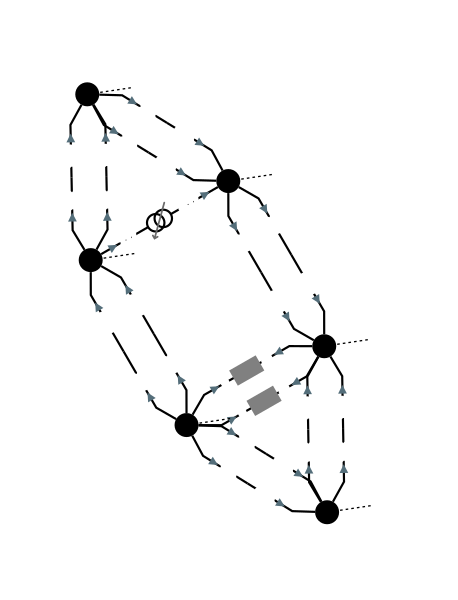

In [57]:
n6.get_network_area_diagram()

In the base case (N), since the generating units and the loads are located in the south, the network is less impedant and we see that the flows pass mostly through it. There is also flow on the PST, and to the north.

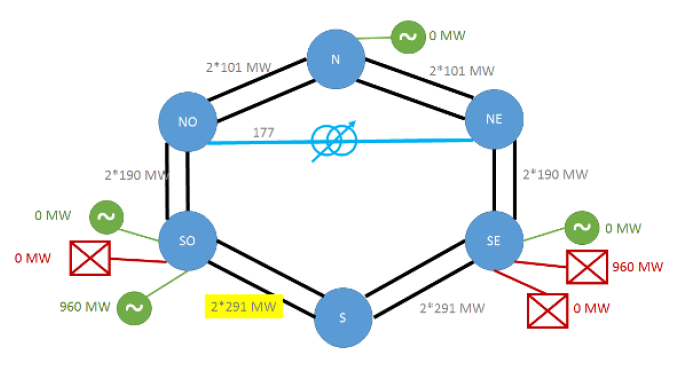

Now, we consider the N-1 case of the `S_SO_1` line contingency:

In [58]:
n6.disconnect(id='S_SO_1')

True

In [59]:
results = pp.loadflow.run_dc(n6)

In [60]:
results

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, iteration_count=0, slack_bus_id='NE_poste_0', slack_bus_active_power_mismatch=-0.0, distributed_active_power=nan)]

In [61]:
n6.get_lines()

,name,r,x,g1,b1,g2,b2,p1,q1,i1,p2,q2,i2,voltage_level1_id,voltage_level2_id,bus1_id,bus2_id,connected1,connected2
id,,,,,,,,,,,,,,,,,,,
NO_N_1,,1.0,1.0,0.0,0.0,0.0,0.0,125.250843,NaN,NaN,-125.250843,NaN,NaN,NO_poste,N_poste,NO_poste_0,N_poste_0,True,True
NO_N_2,,2.0,1.0,0.0,0.0,0.0,0.0,125.250843,NaN,NaN,-125.250843,NaN,NaN,NO_poste,N_poste,NO_poste_0,N_poste_0,True,True
S_SE_1,,3.0,1.0,0.0,0.0,0.0,0.0,242.100337,NaN,NaN,-242.100337,NaN,NaN,S_poste,SE_poste,S_poste_0,SE_poste_0,True,True
S_SE_2,,4.0,1.0,0.0,0.0,0.0,0.0,242.100337,NaN,NaN,-242.100337,NaN,NaN,S_poste,SE_poste,S_poste_0,SE_poste_0,True,True
S_SO_1,,5.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,S_poste,SO_poste,,,False,False
S_SO_2,,6.0,1.0,0.0,0.0,0.0,0.0,-484.200674,NaN,NaN,484.200674,NaN,NaN,S_poste,SO_poste,S_poste_0,SO_poste_0,True,True
SO_NO_1,,7.0,1.0,0.0,0.0,0.0,0.0,237.899663,NaN,NaN,-237.899663,NaN,NaN,SO_poste,NO_poste,SO_poste_0,NO_poste_0,True,True
SO_NO_2,,8.0,1.0,0.0,0.0,0.0,0.0,237.899663,NaN,NaN,-237.899663,NaN,NaN,SO_poste,NO_poste,SO_poste_0,NO_poste_0,True,True
NE_N_1,,9.0,1.0,0.0,0.0,0.0,0.0,-125.250843,NaN,NaN,125.250843,NaN,NaN,NE_poste,N_poste,NE_poste_0,N_poste_0,True,True


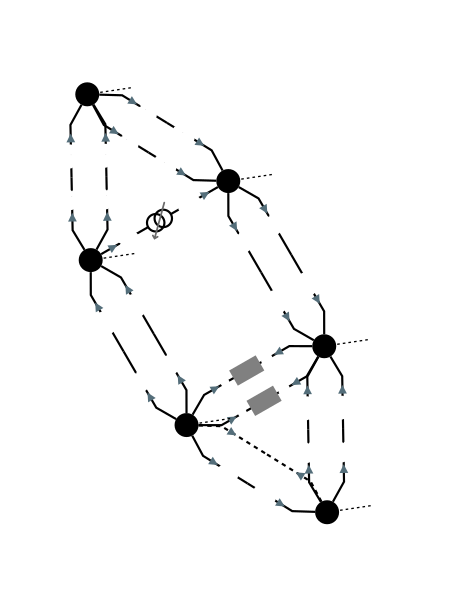

In [62]:
n6.get_network_area_diagram()

N-1 is not respected:

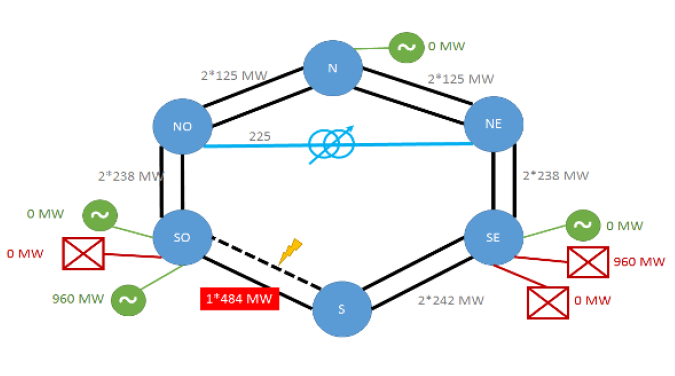

## 4 - Security Analysis

Before performing security analysis, we will reconnect the `S_SO_1` line and consider the second hourly time step. 

In [63]:
n6.connect(id='S_SO_1')

True

In [64]:
n6.update_generators(id='SO_G1', target_p=960)
n6.update_generators(id='SO_G2', target_p=0)
n6.update_generators(id='SE_G', target_p=0)

In [65]:
n6.get_generators()

,name,energy_source,target_p,min_p,max_p,min_q,max_q,rated_s,reactive_limits_kind,target_v,target_q,voltage_regulator_on,regulated_element_id,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,,,,,,,,,,
SO_G1,,THERMAL,960.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G1,-0.0,-0.0,NaN,SO_poste,SO_poste_0,True
SO_G2,,THERMAL,0.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G2,-960.0,-0.0,NaN,SO_poste,SO_poste_0,True
SE_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,6.45498,True,SE_G,-0.0,-0.0,NaN,SE_poste,SE_poste_0,True
N_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,7.48158,True,N_G,-0.0,-0.0,NaN,N_poste,N_poste_0,True


### 4.1 - DC security analysis

To perform a security analysis, you need at least one network and one contingency on that network. In the result, there are violations detected with the initial load flow on the network. These violations are collected in the pre_contingency_result. The results also contain the violations caused by the contingency, they are collected by contingency in post_contingency_results:

In [66]:
security_analysis = pp.security.create_analysis()

In [67]:
security_analysis.add_single_element_contingency('S_SO_1', 'First contingency')

In [68]:
sa_result = security_analysis.run_dc(n6)

In [69]:
sa_result.pre_contingency_result 

PreContingencyResult(, status=CONVERGED, limit_violations=[0])

There is no pre contingency violations because the base case is secured.

In [70]:
sa_result.post_contingency_results

{'First contingency': PostContingencyResult(contingency_id='First contingency', status=CONVERGED, limit_violations=[2])}

In [71]:
sa_result.limit_violations

subject_name limit_type limit_name       limit  \
contingency_id    subject_id                                                  
First contingency S_SO_2                     CURRENT        10'  600.000000   
                  S_SO_2                     CURRENT  permanent  500.000061   

                              acceptable_duration  limit_reduction  \
contingency_id    subject_id                                         
First contingency S_SO_2                        1              1.0   
                  S_SO_2               2147483647              1.0   

                                   value side  
contingency_id    subject_id                   
First contingency S_SO_2      735.666815  ONE  
                  S_SO_2      735.666815  TWO

In [72]:
n6.get_operational_limits().loc['S_SO_2']

,element_type,side,name,type,value,acceptable_duration
element_id,,,,,,
S_SO_2,LINE,ONE,permanent_limit,CURRENT,5.000001e+02,-1
S_SO_2,LINE,ONE,20',CURRENT,5.500000e+02,1200
S_SO_2,LINE,ONE,10',CURRENT,6.000000e+02,600
S_SO_2,LINE,ONE,1',CURRENT,1.797693e+308,1
S_SO_2,LINE,TWO,permanent_limit,CURRENT,5.000001e+02,-1


The contingency on the `S_SO_1` line leads to an overload on the `S_SO_2` line. 

### 4.2 - Adding monitored Elements

This feature is used to obtain information on various elements of the network after the load flow computations. Information can be obtained on buses, branches and three-windings transformers.

In [73]:
sa = pp.security.create_analysis()

In [74]:
sa.add_single_element_contingencies(['S_SO_1'])

In [75]:
sa.add_monitored_elements(branch_ids=['S_SO_2', 'SO_NO_1', 'SO_NO_2', 'S_SO_1'])

It also possible to get flow transfer on monitored branches in case of N-1 branch contingencies.

In [76]:
sa_result = sa.run_dc(n6)

In [77]:
sa_result.branch_results

p1  q1          i1  \
contingency_id operator_strategy_id branch_id                               
                                    SO_NO_2    189.479628 NaN  287.884510   
                                    SO_NO_1    189.479628 NaN  287.884510   
                                    S_SO_2    -290.520372 NaN  441.400040   
                                    S_SO_1    -290.520372 NaN  441.400040   
S_SO_1                              S_SO_1            NaN NaN         NaN   
                                    S_SO_2    -484.200674 NaN  735.666815   
                                    SO_NO_1    237.899663 NaN  361.451143   
                                    SO_NO_2    237.899663 NaN  361.451143   

                                                       p2  q2          i2  \
contingency_id operator_strategy_id branch_id                               
                                    SO_NO_2   -189.479628 NaN  287.884510   
                                    SO_NO_1   -189.479628 NaN  287.884510   
                                    S_SO_2     290.520372 NaN  441.400040   
                                    S_SO_1     290.520372 NaN  441.400040   
S_SO_1                              S_SO_1            NaN NaN         NaN   
                                    S_SO_2     484.200674 NaN  735.666815   
                                    SO_NO_1   -237.899663 NaN  361.451143   
                                    SO_NO_2   -237.899663 NaN  361.451143   

                                               flow_transfer  
contingency_id operator_strategy_id branch_id                 
                                    SO_NO_2              NaN  
                                    SO_NO_1              NaN  
                                    S_SO_2               NaN  
                                    S_SO_1               NaN  
S_SO_1                              S_SO_1               NaN  
                                    S_SO_2               NaN  
                                    SO_NO_1              NaN  
                                    SO_NO_2              NaN

After the contingency of the line `S_SO_1`, 2/3 of the flow goes to the branch `S_SO_2`, 1/6 to the branch `SO_NO_1` and 1/6 to the branch `SO_NO_2`. It is calculated that the limit is exceeded on the branch `S_SO_2`. However, the excess of 84 MW could transit on `SO_NO_1` and `SO_NO_2`. There are four possible curative remedial actions for the S_SO_1 contingency:

- Open bus coupler on `SO` (resulting in splitting SO station into two nodes)
- Open bus coupler on `S` (resulting in splitting S station into two nodes)
- Open both couplers
- Open line `S_SO_2`


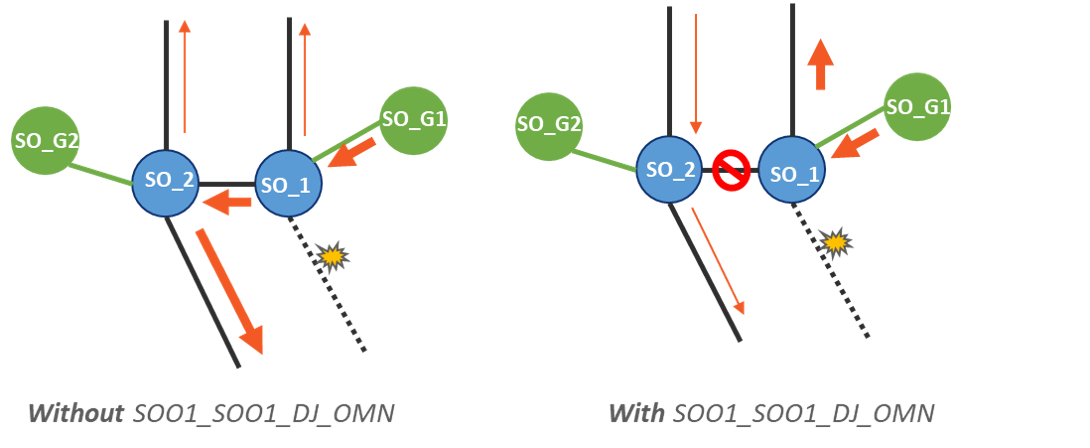

## 5 - Sensitivity Analysis

### 5.1 - DC sensitivity analysis

To perform a sensitivity analysis, you must first define the “factors” you want to compute. What we call a factor is the impact of a small variation of a variable, typically the active power injection of a generator, a load or a phase shifter, on a function, typically the active power flow on a branch. 

To make the definition of those factors easier, `pypowsybl` provides a method to define the variables (injection, phase shifter) through their ids (variables_ids) and the functions through the branch ids (branches_ids). We obtain a matrix of sensitivities as a result:

In [78]:
analysis = pp.sensitivity.create_dc_analysis()
analysis.add_branch_flow_factor_matrix(branches_ids=['S_SO_1', 'S_SO_2'], variables_ids=['SE_G'])
result = analysis.run(n6)
result.get_reference_matrix()

,S_SO_1,S_SO_2
reference_values,-290.520372,-290.520372


In [79]:
result.get_sensitivity_matrix()

,S_SO_1,S_SO_2
SE_G,0.3,0.3


The result can be interpreted in the following way: an increase of 1 MW on generator SE_G impacts the lines S_SO_1 and S_SO_2 with a 0.3 MW increase of the active power flow from side 2 to side 1.


### 5.2 - Zone to zone sensitivity: PTDF computation

This zone to zone sensitivity feature is better known as Power Transfer Distribution Factor (PTDF).

Consider now that the node `SE` is now in Italy:

In [94]:
n6b = pp.network.create_metrix_tutorial_six_buses_network()
n6b.update_substations(id=['SE'], TSO=['Terna'], country=['IT'])
n6b.update_substations(id=['NO', 'S', 'SO', 'N'], TSO=['RTE', 'RTE', 'RTE', 'RTE'], country=['FR', 'FR', 'FR', 'FR'])

In [95]:
pp.loadflow.run_dc(n6b)

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, iteration_count=0, slack_bus_id='NE_poste_0', slack_bus_active_power_mismatch=4.440892098500626e-14, distributed_active_power=nan)]

In [96]:
n6b.get_substations()

,name,TSO,geo_tags,country
id,,,,
NO,,RTE,,FR
S,,RTE,,FR
SO,,RTE,,FR
SE,,Terna,,IT
N,,RTE,,FR


In [98]:
n6b.get_generators()

,name,energy_source,target_p,min_p,max_p,min_q,max_q,rated_s,reactive_limits_kind,target_v,target_q,voltage_regulator_on,regulated_element_id,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,,,,,,,,,,
SO_G1,,THERMAL,480.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G1,-436.521739,-0.0,NaN,SO_poste,SO_poste_0,True
SO_G2,,THERMAL,480.0,0.0,2000.0,NaN,NaN,NaN,CURVE,406.450043,2.35231,True,SO_G2,-436.521739,-0.0,NaN,SO_poste,SO_poste_0,True
SE_G,,THERMAL,100.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,6.45498,True,SE_G,-86.956522,-0.0,NaN,SE_poste,SE_poste_0,True
N_G,,THERMAL,0.0,0.0,600.0,NaN,NaN,NaN,CURVE,406.450043,7.48158,True,N_G,-0.000000,-0.0,NaN,N_poste,N_poste_0,True


In [99]:
n6b.get_loads()

,name,type,p0,q0,p,q,i,voltage_level_id,bus_id,connected
id,,,,,,,,,,
SO_L,,UNDEFINED,480.0,4.8,480.0,4.8,NaN,SO_poste,SO_poste_0,True
SE_L1,,UNDEFINED,480.0,4.8,480.0,4.8,NaN,SE_poste,SE_poste_0,True
SE_L2,,UNDEFINED,0.0,4.8,0.0,4.8,NaN,SE_poste,SE_poste_0,True


In [100]:
zone_fr = pp.sensitivity.create_country_zone(n6b, 'FR')
zone_it = pp.sensitivity.create_country_zone(n6b, 'IT')

<enum 'ZoneKeyType'>
<enum 'ZoneKeyType'>
True
<enum 'ZoneKeyType'>
<enum 'ZoneKeyType'>
True


In [102]:
zone_fr.shift_keys_by_injections_ids

{'SO_G1': 480.0, 'SO_G2': 480.0, 'N_G': 0.0}

In [103]:
params = pp.loadflow.Parameters(distributed_slack=False)
sa = pp.sensitivity.create_dc_analysis()
sa.set_zones([zone_fr, zone_it])

In [104]:
sa.add_branch_flow_factor_matrix(branches_ids=['S_SE_1', 'S_SE_2'], variables_ids=['FR', 'IT'])

In [105]:
ptdf_results = sa.run(n6b, params)
m1 = ptdf_results.get_branch_flows_sensitivity_matrix()

In [106]:
m1

,S_SE_1,S_SE_2
FR,0.2,0.2
IT,-0.1,-0.1


1 MW active power transfer from FR zone to IT zone will be responsible of a variation of 0.3 MW on the border line S_SE_1.

Let’s obtain that directly. After a sensitivity analysis where we should set the zones, we are able to ask for a FR zone to slack sensitivity, a FR to IT zone to zone sensitivity, a IT to FR zone to zone sensitivity and a IT zone to slack sensitivity, on all the border lines ‘S_SE_1’, ‘S_SE_2’, ‘SE_NE_1’ and ‘SE_NE_2’.

In [107]:
sa = pp.sensitivity.create_dc_analysis()
sa.set_zones([zone_fr, zone_it])
sa.add_branch_flow_factor_matrix(branches_ids=['S_SE_1', 'S_SE_2', 'SE_NE_1', 'SE_NE_2'], variables_ids=['FR', ('FR', 'IT'), ('IT', 'FR'), 'IT'])
ptdf_result = sa.run(n6b, params)

In [108]:
m2 = ptdf_result.get_branch_flows_sensitivity_matrix()
m2

,S_SE_1,S_SE_2,SE_NE_1,SE_NE_2
FR,0.2,0.2,0.2,0.2
FR -> IT,0.3,0.3,-0.2,-0.2
IT -> FR,-0.3,-0.3,0.2,0.2
IT,-0.1,-0.1,0.4,0.4


We can see that:
- an increase of 1 MW on the FR zone net position leads to an increase of 0.2 MW on the flow of all the border lines
- moving the flow of 1 MW from FR to IT leads to an increase of 0.3 MW on the flow of lines S_SE_1 and S_SE_2 and a decrease of 0.2 MW on the flow of lines SE_NE_1 and SE_NE_2
- moving the flow of 1 MW from IT to FR leads to a decrease of 0.3 MW on the flow of lines S_SE_1 and S_SE_2 and an increase of 0.2 MW on the flow of lines SE_NE_1 and SE_NE_2
- an increase of 1 MW on the IT zone net position leads to a decrease of 0.1 MW on the flow of lines S_SE_1 and S_SE_2 and an increase of 0.4 MW on the flow of lines SE_NE_1 and SE_NE_2